# Metadata

```yaml
course:   DS 5001 
module:   Final Project
topic:    Text Analysis and Exploration
author:   Eric Tria
date:     2 May 2023
```

# Student Info

```yaml
name:     Eric Tria
user_id:  emt4wf
email:    emt4wf@virginia.edu
```

# Text Analysis and Exploration

In [1]:
import pandas as pd
import numpy as np

from lib.text_helper import TextHelper
from lib.corpus_enhancer import CorpusEnhancer

In [2]:
final_dir = 'final/'
series_prefixes = ['PNR', 'B99', 'OFFICE']

OHCO = ['series_id', 'season_id', 'episode_id', 'scene_id', 'line_id', 'token_id']
TOKENS = OHCO[:6]
LINES = OHCO[:5]
SCENES = OHCO[:4]
EPISODES = OHCO[:3]
SEASONS = OHCO[:2]
SERIES = OHCO[:1]

colors = 'YlGnBu'

In [3]:
text_helper = TextHelper()

In [4]:
CORPUS_RAW = pd.read_csv(final_dir + 'ALL-CORPUS.csv')
VOCAB_EPS_RAW = pd.read_csv(final_dir + 'ALL-VOCAB-EPS.csv')
LIB_RAW = pd.read_csv(final_dir + 'ALL-LIB.csv')
LIB_EPS_RAW = pd.read_csv(final_dir + 'ALL-LIB-EPS.csv')

## 1. Clustering

The first thing we will check is if the any of the seasons between the 3 TV series are related in some way.

We will load the combined CORPUS and set the OHCO to EPISODES

In [5]:
CORPUS_CLUST = CORPUS_RAW.copy()
CORPUS_CLUST = CORPUS_CLUST.set_index(EPISODES).drop(list(set(OHCO) - set(EPISODES)), axis = 1)

CORPUS_CLUST

Unnamed: 0         pos_tuple   pos  \
series_id   season_id episode_id                                       
parksandrec 1         1                    0  ('Hello.', 'NN')    NN   
                      1                    1     ('Hi.', 'NN')    NN   
                      1                    2    ('My', 'PRP$')  PRP$   
                      1                    3    ('name', 'NN')    NN   
                      1                    4     ('is', 'VBZ')   VBZ   
...                                      ...               ...   ...   
theoffice   9         23              564623    ('that', 'IN')    IN   
                      23              564624    ('kind', 'NN')    NN   
                      23              564625      ('of', 'IN')    IN   
                      23              564626     ('the', 'DT')    DT   
                      23              564627  ('point?', 'NN')    NN   

                                 token_str term_str  
series_id   season_id episode_id                     
parksandrec 1         1             Hello.    hello  
                      1                Hi.       hi  
                      1                 My       my  
                      1               name     name  
                      1                 is       is  
...                                    ...      ...  
theoffice   9         23              that     that  
                      23              kind     kind  
                      23                of       of  
                      23               the      the  
                      23            point?    point  

[1563801 rows x 5 columns]

In [6]:
VOCAB_CLUST = VOCAB_EPS_RAW.copy()
VOCAB_CLUST = VOCAB_CLUST.set_index('term_str')

VOCAB_CLUST

,n,n_chars,p,i,h,max_pos,n_pos,cat_pos,stop,tfidf_mean,tfidf_sum,tfidf_median,tfidf_max,dfidf
term_str,,,,,,,,,,,,,,
0,17,1,1.087610e-05,16.488480,0.000179,CD,2,"{'NN', 'CD'}",0,0.001519,0.022779,0.001325,0.003502,73.603359
00,1,2,6.397703e-07,20.575943,0.000013,CD,1,{'CD'},0,0.002166,0.002166,0.002166,0.002166,8.813781
000003,1,6,6.397703e-07,20.575943,0.000013,NN,1,{'NN'},0,0.002497,0.002497,0.002497,0.002497,8.813781
000007044,1,9,6.397703e-07,20.575943,0.000013,CD,1,{'CD'},0,0.002036,0.002036,0.002036,0.002036,8.813781
001834310,1,9,6.397703e-07,20.575943,0.000013,CD,1,{'CD'},0,0.001975,0.001975,0.001975,0.001975,8.813781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ühumming,1,8,6.397703e-07,20.575943,0.000013,NN,1,{'NN'},0,0.003122,0.003122,0.003122,0.003122,8.813781
ümusical,4,8,2.559081e-06,18.575943,0.000048,NN,1,{'NN'},0,0.012489,0.012489,0.012489,0.012489,8.813781
ünew,1,4,6.397703e-07,20.575943,0.000013,NN,1,{'NN'},0,0.002973,0.002973,0.002973,0.002973,8.813781


Reduce the number of features in the returned TFIDF matrix to the 1000 most significant terms, using DFIDF as your significance measure and only using terms whose maximum part-of-speech belongs to this set: `NN NNS VB VBD VBG VBN VBP VBZ JJ JJR JJS RB RBR RBS`. Note, these are all open categories, excluding proper nounns.

In [7]:
max_pos_set = ['NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'RB', 'RBR', 'RBS']
VOCAB_SIG = VOCAB_CLUST.copy()
VOCAB_SIG = VOCAB_SIG[VOCAB_SIG['max_pos'].isin(max_pos_set)]
VOCAB_SIG = VOCAB_SIG.sort_values('dfidf', ascending = False).head(1000)

VOCAB_SIG

,n,n_chars,p,i,h,max_pos,n_pos,cat_pos,stop,tfidf_mean,tfidf_sum,tfidf_median,tfidf_max,dfidf
term_str,,,,,,,,,,,,,,
lady,247,4,0.000158,12.627575,0.001995,NN,2,"{'JJ', 'NN'}",0,0.000621,0.103006,0.000452,0.002362,238.831132
clear,253,5,0.000162,12.592949,0.002038,JJ,2,"{'JJ', 'NN'}",0,0.000619,0.102788,0.000475,0.003921,238.831132
answer,236,6,0.000151,12.693300,0.001917,NN,2,"{'VB', 'NN'}",0,0.000584,0.097014,0.000445,0.001959,238.831132
lose,240,4,0.000154,12.669052,0.001945,VB,4,"{'JJ', 'VB', 'VBP', 'NN'}",0,0.000603,0.100073,0.000445,0.004540,238.831132
met,242,3,0.000155,12.657079,0.001960,NN,2,"{'NNP', 'NN'}",0,0.000605,0.100446,0.000471,0.001747,238.831132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
meat,110,4,0.000070,13.794583,0.000971,NN,1,{'NN'},0,0.001341,0.085852,0.000882,0.006930,180.081996
tired,89,5,0.000057,14.100209,0.000803,VBN,2,"{'NN', 'VBN'}",0,0.001137,0.072737,0.000835,0.005561,180.081996
destroy,84,7,0.000054,14.183625,0.000762,NN,1,{'NN'},0,0.001061,0.067891,0.000855,0.004072,180.081996


In [9]:
SIG_TERMS = VOCAB_SIG.index.to_list()

BOW_CLUST = text_helper.create_bow(CORPUS_CLUST, EPISODES)
TFIDF_CLUST, _ = text_helper.compute_tfidf_dfidf(BOW_CLUST)
TFIDF_STACKED = TFIDF_CLUST.stack()
TFIDF_SIG = TFIDF_STACKED[TFIDF_STACKED.index.isin(SIG_TERMS, level = 'term_str')]
TFIDF_MATRIX = TFIDF_SIG.unstack()
TFIDF_MATRIX

Using TF method: sum


term_str                             able  absolutely    accept  accident  \
series_id  season_id episode_id                                             
brooklyn99 1         1           0.000000    0.000375  0.000000  0.000000   
                     2           0.000484    0.000000  0.000000  0.000000   
                     3           0.000454    0.000365  0.000750  0.000000   
                     4           0.000000    0.000000  0.000000  0.000000   
                     5           0.000000    0.000000  0.000000  0.000000   
...                                   ...         ...       ...       ...   
theoffice  9         19          0.000541    0.000000  0.000000  0.000935   
                     20          0.000000    0.000497  0.000000  0.000000   
                     21          0.000367    0.000000  0.001210  0.000634   
                     22          0.000000    0.000494  0.000000  0.000000   
                     23          0.000000    0.000000  0.000441  0.000000   

term_str                         according       act    acting    actual  \
series_id  season_id episode_id                                            
brooklyn99 1         1                 0.0  0.000000  0.000000  0.000000   
                     2                 0.0  0.000642  0.000000  0.000000   
                     3                 0.0  0.000000  0.000000  0.000000   
                     4                 0.0  0.001228  0.000000  0.000000   
                     5                 0.0  0.000000  0.000000  0.000000   
...                                    ...       ...       ...       ...   
theoffice  9         19                0.0  0.001435  0.000000  0.000000   
                     20                0.0  0.001640  0.000000  0.000000   
                     21                0.0  0.000486  0.001722  0.000000   
                     22                0.0  0.000000  0.000000  0.000507   
                     23                0.0  0.000355  0.000419  0.000000   

term_str                              add  address  ...  yesterday       yet  \
series_id  season_id episode_id                     ...                        
brooklyn99 1         1           0.000719      0.0  ...   0.000000  0.000000   
                     2           0.000000      0.0  ...   0.000000  0.000000   
                     3           0.000000      0.0  ...   0.000551  0.000266   
                     4           0.000715      0.0  ...   0.000000  0.000271   
                     5           0.000000      0.0  ...   0.000560  0.000000   
...                                   ...      ...  ...        ...       ...   
theoffice  9         19          0.000000      0.0  ...   0.000000  0.000316   
                     20          0.000954      0.0  ...   0.000749  0.000000   
                     21          0.000000      0.0  ...   0.000888  0.000214   
                     22          0.000000      0.0  ...   0.000000  0.000359   
                     23          0.000000      0.0  ...   0.000000  0.000156   

term_str                             york      youd     youll     young  \
series_id  season_id episode_id                                           
brooklyn99 1         1           0.000000  0.000000  0.000227  0.000000   
                     2           0.000000  0.000000  0.000000  0.000000   
                     3           0.000000  0.000300  0.000000  0.000000   
                     4           0.000000  0.000000  0.000225  0.000000   
                     5           0.000000  0.000000  0.000225  0.000000   
...                                   ...       ...       ...       ...   
theoffice  9         19          0.000000  0.000000  0.000000  0.000000   
                     20          0.000000  0.000000  0.000301  0.000000   
                     21          0.000000  0.000000  0.000178  0.000000   
                     22          0.000000  0.000000  0.000448  0.000372   
                     23          0.000696  0.000177  0.000260  0.000

In [10]:
TFIDF_COLLAPSED = TFIDF_MATRIX.groupby(SEASONS).mean()
TFIDF_COLLAPSED

term_str                   able  absolutely    accept  accident  according  \
series_id   season_id                                                        
brooklyn99  1          0.000169    0.000084  0.000143  0.000112   0.000285   
            2          0.000211    0.000124  0.000161  0.000065   0.000132   
            3          0.000123    0.000210  0.000065  0.000304   0.000205   
            4          0.000152    0.000213  0.000063  0.000358   0.000061   
            5          0.000302    0.000272  0.000120  0.000031   0.000121   
            6          0.000405    0.000081  0.000226  0.000179   0.000176   
            7          0.000181    0.000167  0.000208  0.000247   0.000150   
            8          0.000195    0.000247  0.000063  0.000189   0.000466   
parksandrec 1          0.000160    0.000463  0.000137  0.000000   0.000000   
            2          0.000213    0.000154  0.000141  0.000210   0.000072   
            3          0.000323    0.000176  0.000050  0.000000   0.000106   
            4          0.000128    0.000167  0.000247  0.000149   0.000140   
            5          0.000251    0.000181  0.000234  0.000104   0.000207   
            6          0.000289    0.000185  0.000116  0.000112   0.000167   
            7          0.000229    0.000146  0.000279  0.000132   0.000000   
theoffice   1          0.000094    0.000395  0.000000  0.000000   0.000152   
            2          0.000140    0.000156  0.000042  0.000239   0.000048   
            3          0.000062    0.000368  0.000294  0.000106   0.000048   
            4          0.000167    0.000259  0.000139  0.000303   0.000080   
            5          0.000132    0.000197  0.000145  0.000040   0.000039   
            6          0.000372    0.000242  0.000102  0.000059   0.000137   
            7          0.000258    0.000248  0.000259  0.000199   0.000112   
            8          0.000259    0.000207  0.000194  0.000208   0.000043   
            9          0.000076    0.000264  0.000286  0.000111   0.000132   

term_str                    act    acting    actual       add   address  ...  \
series_id   season_id                                                    ...   
brooklyn99  1          0.000198  0.000231  0.000035  0.000233  0.000187  ...   
            2          0.000385  0.000092  0.000130  0.000098  0.000201  ...   
            3          0.000162  0.000189  0.000067  0.000152  0.000529  ...   
            4          0.000126  0.000209  0.000000  0.000259  0.000161  ...   
            5          0.000140  0.000111  0.000236  0.000133  0.000123  ...   
            6          0.000312  0.000579  0.000167  0.000052  0.000058  ...   
            7          0.000311  0.000368  0.000197  0.000193  0.000047  ...   
            8          0.000200  0.000174  0.000256  0.000234  0.000450  ...   
parksandrec 1          0.000000  0.000132  0.000144  0.000000  0.000136  ...   
            2          0.000272  0.000096  0.000177  0.000115  0.000146  ...   
            3          0.000079  0.000191  0.000361  0.000312  0.000108  ...   
            4          0.000131  0.000187  0.000281  0.000126  0.000217  ...   
            5          0.000194  0.000061  0.000201  0.000252  0.000036  ...   
            6          0.000090  0.000238  0.000217  0.000136  0.000414  ...   
            7          0.000317  0.000120  0.000378  0.000082  0.000186  ...   
theoffice   1          0.000133  0.000156  0.000000  0.000314  0.000000  ...   
            2          0.000250  0.000044  0.000224  0.000044  0.000189  ...   
            3          0.000086  0.000559  0.000111  0.000000  0.000107  ...   
            4          0.000056  0.000000  0.000139  0.000129  0.000037  ...   
            5          0.000092  0.000063  0.000036  0.000135  0.000148  ...   
            6          0.000168  0.000137  0.000000  0.000153  0.000069  ...   
            7          0.000250  0.000230  0.000163  0.000195  0.000032  ...   
            8          0.000173  0.000148  0.000033

In [12]:
LIB_CLUST = LIB_RAW.copy()
LIB_CLUST = LIB_CLUST.set_index(SEASONS)
LIB_CLUST

Unnamed: 0  num_episodes  year  viewers_millions  \
series_id   season_id                                                     
parksandrec 1                   0             6  2009              6.00   
            2                   1            24  2010              4.60   
            3                   2            16  2011              5.10   
            4                   3            22  2012              4.40   
            5                   4            22  2013              4.06   
            6                   5            22  2014              3.76   
            7                   6            13  2015              4.57   
brooklyn99  1                   0            22  2014              4.80   
            2                   1            23  2015              4.87   
            3                   2            23  2016              3.98   
            4                   3            22  2017              2.87   
            5                   4            22  2018              2.71   
            6                   5            18  2019              3.11   
            7                   6            13  2020              2.69   
            8                   7            10  2021              1.69   
theoffice   1                   0             6  2005              5.40   
            2                   1            22  2006              8.00   
            3                   2            25  2007              8.30   
            4                   3            19  2008              8.04   
            5                   4            28  2009              9.04   
            6                   5            26  2010              8.73   
            7                   6            26  2011              7.73   
            8                   7            24  2012              6.51   
            9                   8            25  2013              5.06   

                       rt_rating           series_name  \
series_id   season_id                                    
parksandrec 1                 68  Parks and Recreation   
            2                 96  Parks and Recreation   
            3                100  Parks and Recreation   
            4                100  Parks and Recreation   
            5                 96  Parks and Recreation   
            6                 96  Parks and Recreation   
            7                 89  Parks and Recreation   
brooklyn99  1                 89    Brooklyn Nine-Nine   
            2                100    Brooklyn Nine-Nine   
            3                 93    Brooklyn Nine-Nine   
            4                100    Brooklyn Nine-Nine   
            5                100    Brooklyn Nine-Nine   
            6                100    Brooklyn Nine-Nine   
            7                 89    Brooklyn Nine-Nine   
            8                 89    Brooklyn Nine-Nine   
theoffice   1                 69            The Office   
            2                100            The Office   
            3                100            The Office   
            4                 83            The Office   
            5                100            The Office   
            6                 73            The Office   
            7                 83            The Office   
            8                 44            The Office   
            9                 79            The Office   

                                       series_season  
series_id   season_id                                 
parksandrec 1          Parks and Recreation Season 1  
            2          Parks and Recreation Season 2  
            3          Parks and Recreation Season 3  
            4          Parks and Recreation Season 4  
            5          Parks and Recreation Season 5  
            6          Parks and Recreation Season 6  
            7          Parks and Recreation Season 7  
brooklyn99  1            Brooklyn Nine-Nine Season 1  
            2

In [13]:
PAIRS = text_helper.generate_clustering_pairs(TFIDF_COLLAPSED, LIB_CLUST)
PAIRS

cityblock    cosine  euclidean   jaccard  \
doc_a            doc_b                                                        
(parksandrec, 1) (parksandrec, 2)   0.126633  0.116567   0.482839  0.025667   
                 (parksandrec, 3)   0.124790  0.134341   0.518345  0.020576   
                 (parksandrec, 4)   0.131693  0.135398   0.520380  0.028659   
                 (parksandrec, 5)   0.133287  0.170217   0.583467  0.024565   
                 (parksandrec, 6)   0.148992  0.191052   0.618145  0.064682   
...                                      ...       ...        ...       ...   
(theoffice, 6)   (theoffice, 8)     0.123539  0.302532   0.777859  0.030832   
                 (theoffice, 9)     0.121225  0.294386   0.767314  0.044012   
(theoffice, 7)   (theoffice, 8)     0.119629  0.290405   0.762109  0.034091   
                 (theoffice, 9)     0.116179  0.274316   0.740697  0.039256   
(theoffice, 8)   (theoffice, 9)     0.108685  0.120537   0.490993  0.042094   

                                         js  
doc_a            doc_b                       
(parksandrec, 1) (parksandrec, 2)  0.221822  
                 (parksandrec, 3)  0.225944  
                 (parksandrec, 4)  0.233945  
                 (parksandrec, 5)  0.236245  
                 (parksandrec, 6)  0.272380  
...                                     ...  
(theoffice, 6)   (theoffice, 8)    0.269420  
                 (theoffice, 9)    0.269612  
(theoffice, 7)   (theoffice, 8)    0.265891  
                 (theoffice, 9)    0.259037  
(theoffice, 8)   (theoffice, 9)    0.243171  

[276 rows x 5 columns]

In [14]:
PAIRS.head().style.background_gradient(colors)

<Figure size 640x480 with 0 Axes>

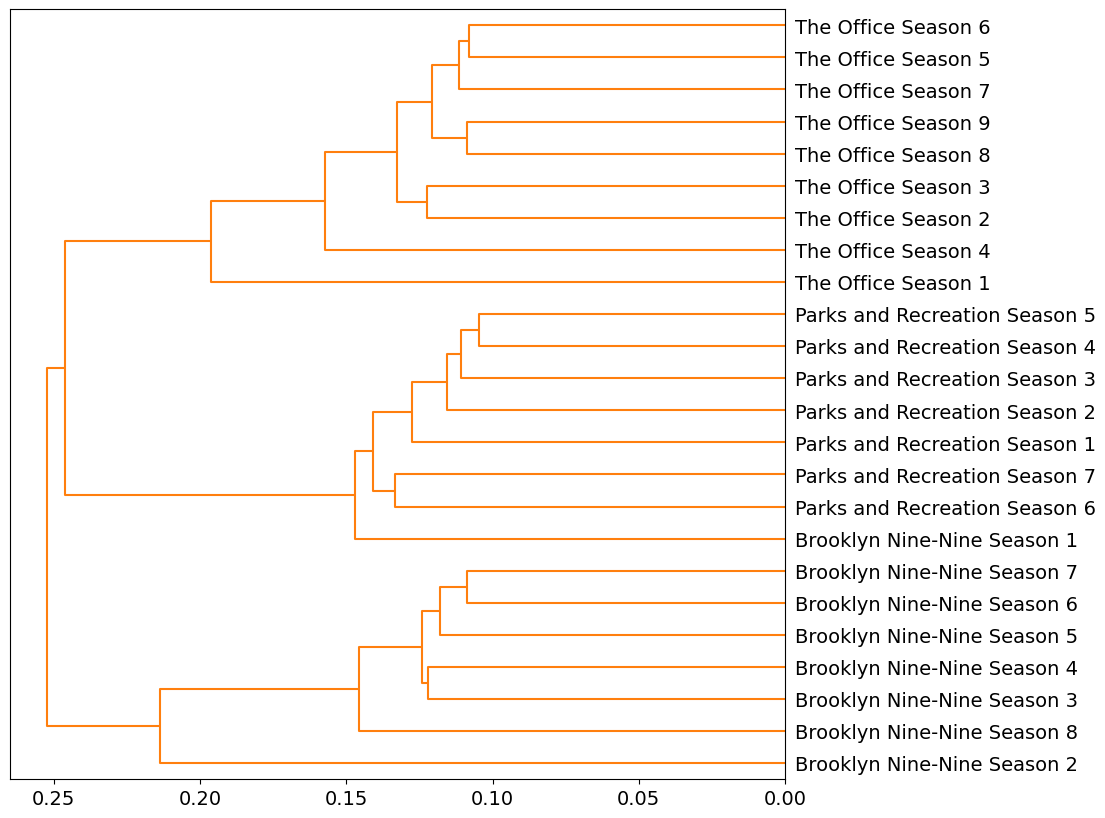

In [16]:
text_helper.hca(LIB_CLUST, PAIRS.cityblock, linkage_method='weighted', color_thresh=1)

<Figure size 640x480 with 0 Axes>

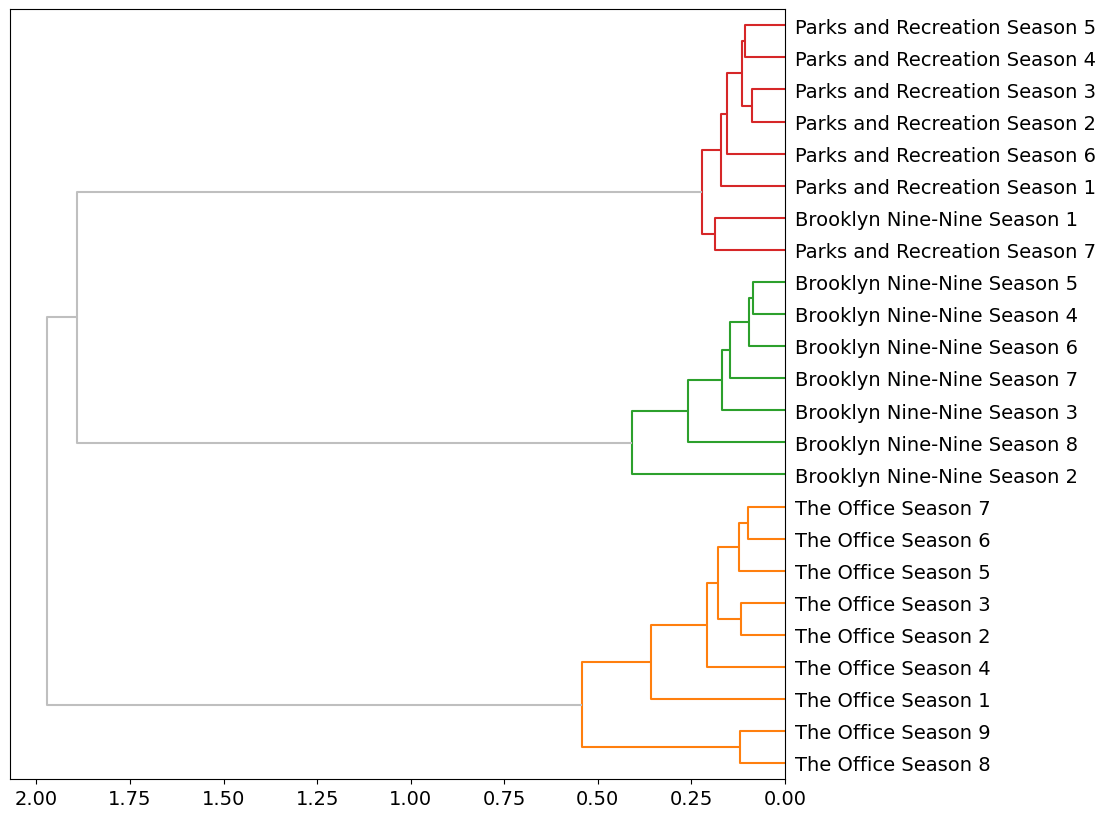

In [17]:
text_helper.hca(LIB_CLUST, PAIRS.cosine, linkage_method='ward', color_thresh=0.9)

<Figure size 640x480 with 0 Axes>

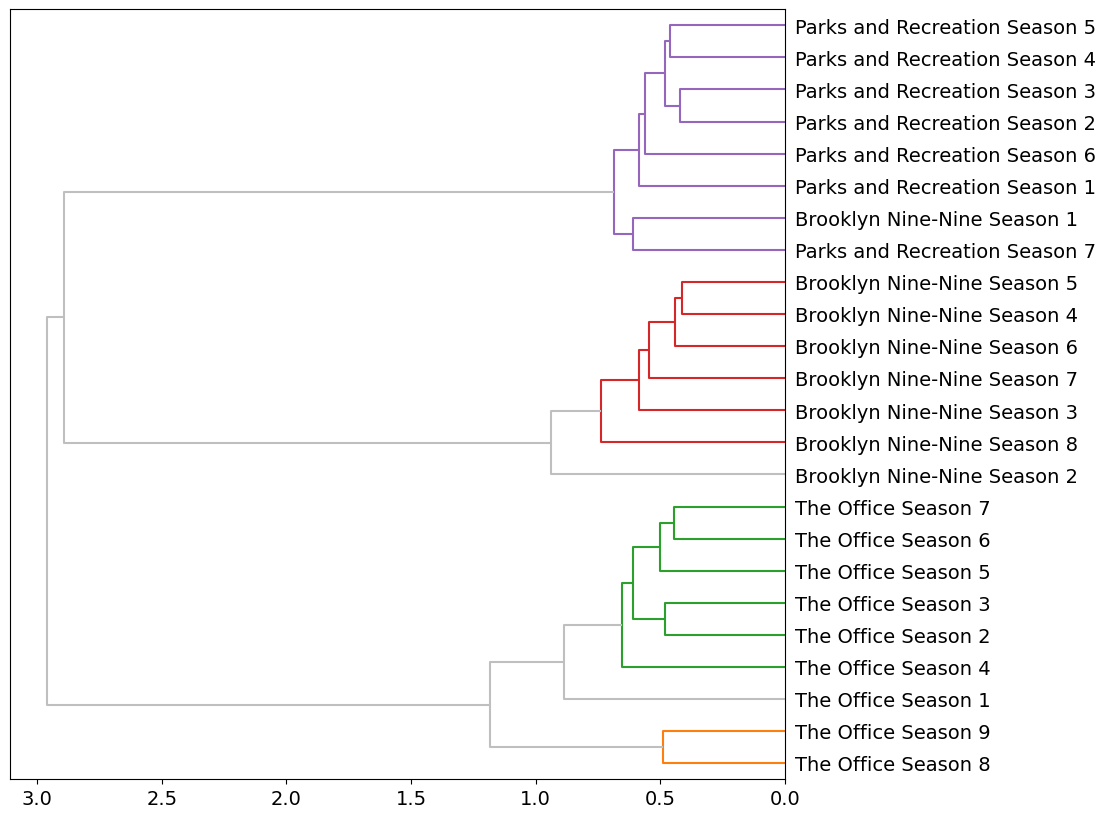

In [18]:
text_helper.hca(LIB_CLUST, PAIRS.euclidean, linkage_method='ward', color_thresh=0.8)

<Figure size 640x480 with 0 Axes>

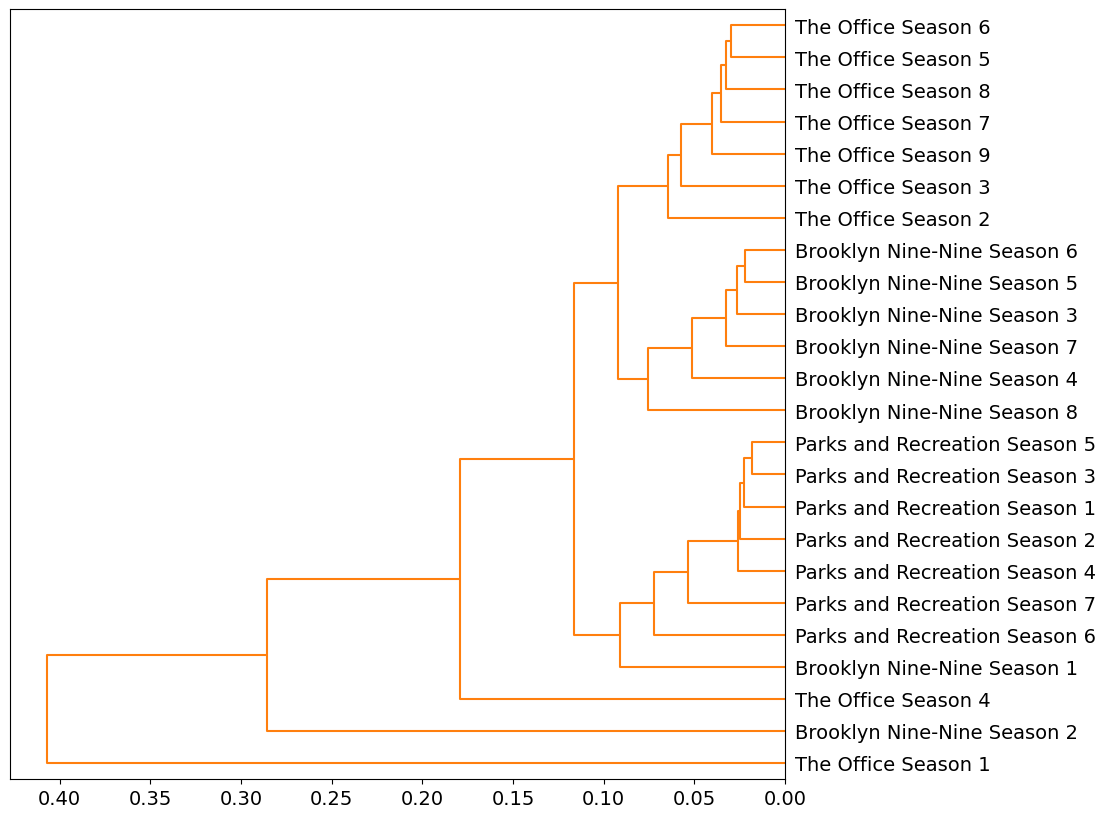

In [19]:
text_helper.hca(LIB_CLUST, PAIRS.jaccard, linkage_method='weighted', color_thresh=0.7)

<Figure size 640x480 with 0 Axes>

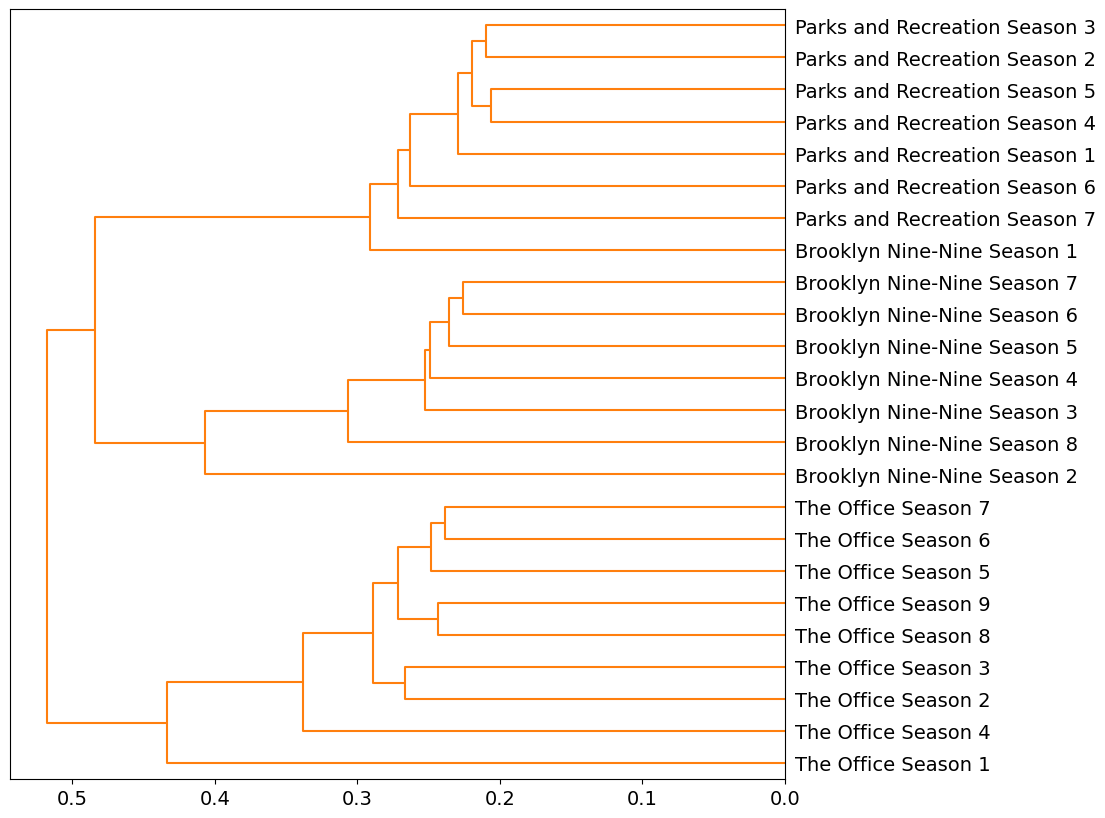

In [20]:
text_helper.hca(LIB_CLUST, PAIRS.js, linkage_method='weighted', color_thresh=0.6)

## 2. PCA

In [21]:
norm_docs = True # This has the effect of exaggerating variance when False
center_term_vectors = True # This has the effect of demoting authorship when False

pca_colors = 'Spectral'

## 3. Topic Modeling

In [22]:
# Parameters for the topic model

ngram_range = [1,2]
n_terms = 4000 # max features for the count vectorizer
n_topics = 20 # number of components for LDA
max_iter = 5 # max iter for LDA
n_top_terms = 7 # number of words used to characterize a topic

In [32]:
CORPUS_TOPIC = CORPUS_RAW.copy()
CORPUS_TOPIC = CORPUS_TOPIC.set_index(SEASONS)
CORPUS_TOPIC

Unnamed: 0  episode_id  scene_id  line_id  token_id  \
series_id   season_id                                                        
parksandrec 1                   0           1         1        1         0   
            1                   1           1         1        1         1   
            1                   2           1         1        2         0   
            1                   3           1         1        2         1   
            1                   4           1         1        2         2   
...                           ...         ...       ...      ...       ...   
theoffice   9              564623          23        15      103         1   
            9              564624          23        15      103         2   
            9              564625          23        15      103         3   
            9              564626          23        15      103         4   
            9              564627          23        15      103         5   

                              pos_tuple   pos token_str term_str  
series_id   season_id                                             
parksandrec 1          ('Hello.', 'NN')    NN    Hello.    hello  
            1             ('Hi.', 'NN')    NN       Hi.       hi  
            1            ('My', 'PRP$')  PRP$        My       my  
            1            ('name', 'NN')    NN      name     name  
            1             ('is', 'VBZ')   VBZ        is       is  
...                                 ...   ...       ...      ...  
theoffice   9            ('that', 'IN')    IN      that     that  
            9            ('kind', 'NN')    NN      kind     kind  
            9              ('of', 'IN')    IN        of       of  
            9             ('the', 'DT')    DT       the      the  
            9          ('point?', 'NN')    NN    point?    point  

[1563801 rows x 9 columns]

In [35]:
THETA, PHI, TOPICS = text_helper.generate_topic_model(
    BAG = SEASONS,
    TOKENS = CORPUS_TOPIC,
    ngram_range = ngram_range,
    n_terms = n_terms,
    n_topics = n_topics,
    max_iter = max_iter,
    n_top_terms = n_top_terms,
    remove_stop = False
)

In [36]:
THETA.sample(20).style.background_gradient(cmap=colors, axis=None)

In [37]:
TOPICS.sort_values(by = 'term_freq', ascending = False).head(20)

term_str,0,1,2,3,4,5,6,label,doc_weight_sum,term_freq
topic_id,,,,,,,,,,
T06,im,oh,dont,youre,right,okay,yeah,"T06 im, oh, dont, youre, right, okay, yeah",6.930884,0.294145
T09,im,oh,okay,dont,yeah,youre,thats,"T09 im, oh, okay, dont, yeah, youre, thats",7.115897,0.286407
T02,im,okay,dont,yeah,right,oh,hey,"T02 im, okay, dont, yeah, right, oh, hey",6.757615,0.268062
T14,okay,im,oh,dont,yeah,right,thats,"T14 okay, im, oh, dont, yeah, right, thats",2.203471,0.090022
T16,im,oh,dont,right,youre,gonna,thats,"T16 im, oh, dont, right, youre, gonna, thats",0.963205,0.055600
T13,ok,saturday,surprise,meredith,basketball,dollars,pam,"T13 ok, saturday, surprise, meredith, basketba...",0.028030,0.000630
T00,100,professor,prints,priority,prison,privacy,private,"T00 100, professor, prints, priority, prison, ...",0.000064,0.000367
T12,100,professor,prints,priority,prison,privacy,private,"T12 100, professor, prints, priority, prison, ...",0.000064,0.000367
T18,100,professor,prints,priority,prison,privacy,private,"T18 100, professor, prints, priority, prison, ...",0.000064,0.000367


In [31]:
VOCAB_CLUST.loc['yeah']

n                              6934
n_chars                           4
p                          0.004436
i                          7.816471
h                          0.034675
max_pos                          NN
n_pos                             3
cat_pos         {'UH', 'NNS', 'NN'}
stop                              0
tfidf_mean                 0.000015
tfidf_sum                  0.006551
tfidf_median               0.000014
tfidf_max                  0.000038
dfidf                      1.441091
Name: yeah, dtype: object